# Group Splitter Validation

Load a trained group splitter model and generate validation plots:
- Load model from checkpoint
- Load validation data
- Generate predictions
- Create evaluation plots (confusion matrices, ROC curves, precision-recall, probability distributions)

In [1]:
import torch
import numpy as np
from pathlib import Path
from datetime import datetime

from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.common.loader import GroupSplitterGraphLoader
from pioneerml.common.evaluation.plots import (
    plot_multilabel_confusion_matrix,
    plot_roc_curves,
    plot_precision_recall_curves,
    plot_embedding_space,
    plot_probability_distributions,
    plot_confidence_analysis,
)
from pioneerml.pipelines.inference.group_splitting import group_splitting_inference_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/jack/python_projects/pioneerML


## List Available Checkpoints

Find all saved model checkpoints and their metadata files.


In [2]:
# List and print all available torchscript exports
model_dir = Path(PROJECT_ROOT) / "trained_models" / "groupsplitter"
checkpoints = sorted(model_dir.glob("*_torchscript.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
if not checkpoints:
    raise ValueError(f"No torchscript models found in {model_dir}")

print(f"Found {len(checkpoints)} model export(s).")
for i, p in enumerate(checkpoints[:10]):
    print(f"[{i}] {p.name}")

print(f"Using latest model: {checkpoints[0].name}")

Found 2 checkpoint(s):
  1. groupsplitter_20260102_112701_group_splitter_optuna_pipeline-2026_01_02-11_26_25_532626_state_dict.pt
     Timestamp:     20260102_112701
     Run:           group_splitter_optuna_pipeline-2026_01_02-11_26_25_532626
     Architecture:  hidden=150, heads=9, layers=2, dropout=0.19683318923607906
  2. groupsplitter_20251207_193129_group_splitter_optuna_pipeline-2025_12_07-19_30_15_976540_state_dict.pt
     Timestamp:     20251207_193129
     Run:           group_splitter_optuna_pipeline-2025_12_07-19_30_15_976540
     Architecture:  hidden=192, heads=7, layers=4, dropout=0.09902375280917053

Using checkpoint: groupsplitter_20260102_112701_group_splitter_optuna_pipeline-2026_01_02-11_26_25_532626_state_dict.pt


## Load Model

Reconstruct the model architecture from metadata and load the saved weights.


In [3]:
# Load model path (latest by default)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = str(checkpoints[0].resolve())

print(f"Model path: {model_path}")
print(f"Device: {device}")


Model loaded successfully on cuda
  Checkpoint: groupsplitter_20260102_112701_group_splitter_optuna_pipeline-2026_01_02-11_26_25_532626_state_dict.pt
  Timestamp: 20260102_112701
  Run: group_splitter_optuna_pipeline-2026_01_02-11_26_25_532626
  Parameters: 516,109


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).


In [4]:
# Load validation parquet inputs and aligned group-classifier priors

def _pick_pred(group_pred_dir: Path, main_path: Path) -> Path | None:
    latest = group_pred_dir / f"{main_path.stem}_preds_latest.parquet"
    if latest.exists():
        return latest
    alt = group_pred_dir / f"{main_path.stem}_preds.parquet"
    if alt.exists():
        return alt
    return None

main_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(main_dir.glob("ml_output_*.parquet"))
# main_paths = main_paths[:1]

group_pred_dir = Path(PROJECT_ROOT) / "data" / "group_classifier"
paired = []
for mp in main_paths:
    gp = _pick_pred(group_pred_dir, mp)
    if gp is not None:
        paired.append((str(mp.resolve()), str(gp.resolve())))

if not paired:
    raise RuntimeError(
        "No aligned main/group-classifier prediction pairs found. "
        "Run group-classifier inference first."
    )

parquet_paths = [p[0] for p in paired]
group_probs_parquet_paths = [p[1] for p in paired]

print(f"Validation files: {len(parquet_paths)}")
for p in parquet_paths:
    print(" -", p)
print(f"Group prior files: {len(group_probs_parquet_paths)}")

Limiting to 1 files (from 11 total files found, max_files=1)
Limiting to 1 files (from 11 total files found, max_files=1)
Loaded 9925 groups from 1 file pairs


Loaded 9925 groups for validation
Validation dataset size: 9925


## Generate Predictions

Run inference on the validation dataset.


In [5]:
# Run inference pipeline in validation mode (loader.mode='train' includes truth targets)
run = group_splitting_inference_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    model_path=model_path,
    output_dir=str((Path(PROJECT_ROOT) / "data" / "group_splitter").resolve()),
    pipeline_config={
        "loader": {
            "config_json": {
                "mode": "train",
                "batch_size": 64,
                "chunk_row_groups": 4,
                "chunk_workers": 0,
                "use_group_probs": True,
            }
        },
        "inference": {"threshold": 0.5},
        "export": {"check_accuracy": True, "write_timestamped": False},
    },
)

inference_outputs = load_step_output(run, "run_group_splitter_inference")
export_info = load_step_output(run, "export_group_splitter_predictions")

predictions = inference_outputs["probs"].to(torch.float32)
targets = inference_outputs["targets"].to(torch.float32)

print("Generated predictions:")
print(f"  Predictions shape: {tuple(predictions.shape)}")
print(f"  Targets shape: {tuple(targets.shape)}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print("export:", export_info)

Generated predictions:
  Predictions shape: torch.Size([248258, 3])
  Targets shape: torch.Size([248258, 3])
  Predictions range: [-73.8618, 104.2926]


## Generate Validation Plots

Create comprehensive evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_splitter"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"group_splitter_{timestamp_str}"

class_names = ["pion", "muon", "mip"]

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")

Generating validation plots in: /home/jack/python_projects/pioneerML/artifacts/validation_plots/group_splitter
Class names: ['pion', 'muon', 'mip']


### Confusion Matrix

The confusion matrix shows how well the model classifies each hit type. It displays the true labels vs predicted labels in a grid format.

**How to interpret:**
- **Diagonal elements** (top-left to bottom-right): Correct predictions. Higher values indicate better performance for that class.
- **Off-diagonal elements**: Misclassifications. Shows which classes are being confused with each other.
- **Normalized values**: Percentages show the proportion of each true class that was predicted as each class. A perfect classifier would have 100% on the diagonal and 0% elsewhere.

**What to look for:**
- High diagonal values indicate good classification
- Off-diagonal patterns reveal systematic confusions



1. Generating confusion matrices...


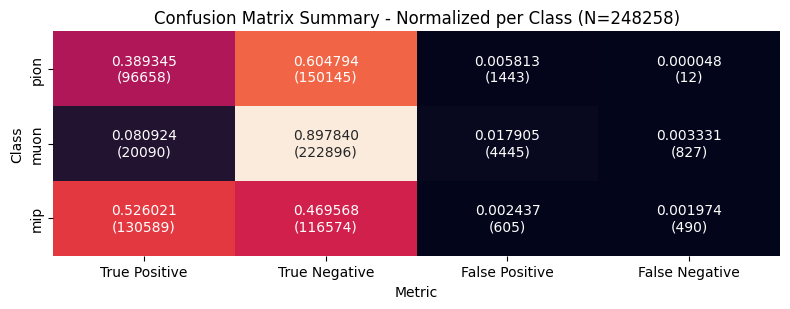

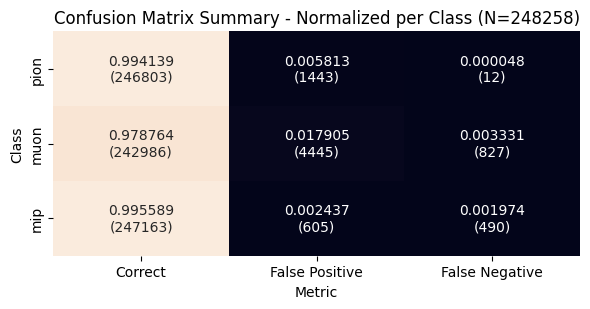

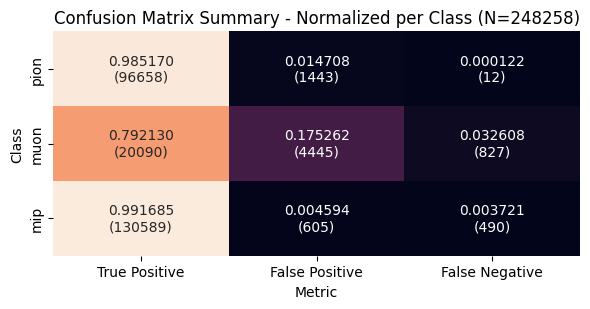

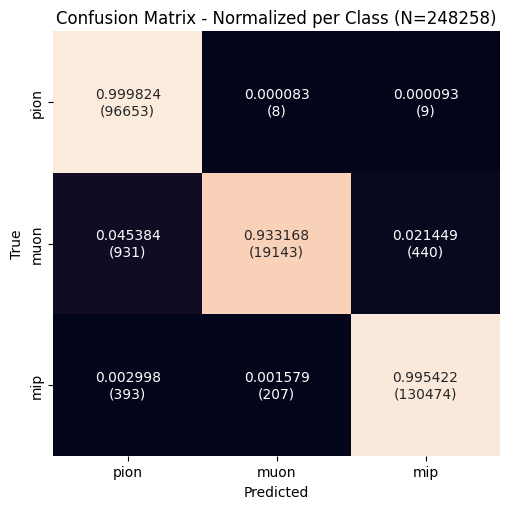

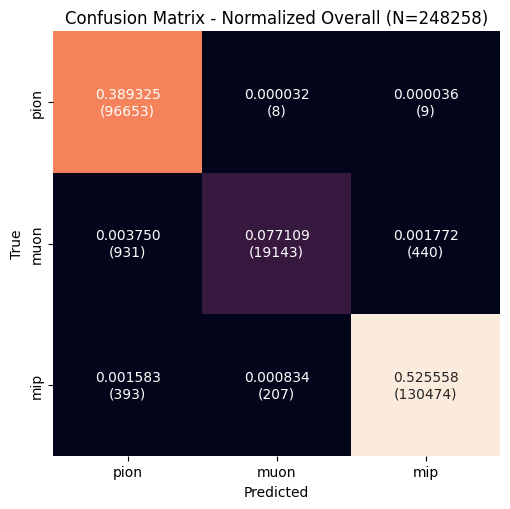

In [7]:
# 1. Confusion Matrix

print("1. Generating confusion matrices...")

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="default",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="correct_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_correct.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="true_positive_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_true_positives.png",
    show=True,
)

### ROC Curves (Receiver Operating Characteristic)

ROC curves show the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) at different classification thresholds.

**How to interpret:**
- **X-axis (False Positive Rate)**: Proportion of negative samples incorrectly classified as positive. Lower is better.
- **Y-axis (True Positive Rate / Recall)**: Proportion of positive samples correctly identified. Higher is better.
- **Diagonal line (AUC = 0.5)**: Random guessing baseline. Any curve above this indicates the model is learning.
- **AUC (Area Under Curve)**: Higher values mean the model can better distinguish between classes.

**What to look for:**
- Curves that hug the top-left corner indicate better performance
- Higher AUC values mean the model can better distinguish between classes



2. Generating ROC curves...


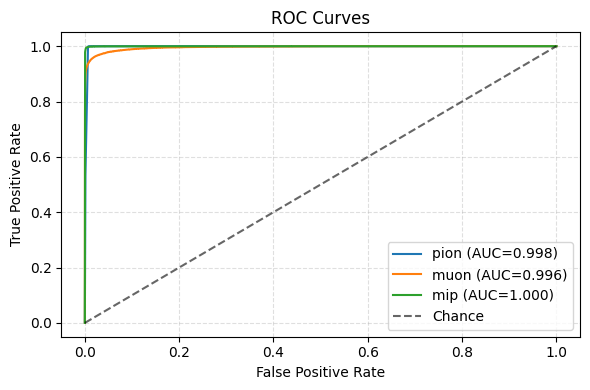

In [8]:
# 2. ROC Curves
print("2. Generating ROC curves...")
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_roc_curves.png",
    show=True,
)

### Precision-Recall Curves

Precision-Recall curves show the relationship between precision (accuracy of positive predictions) and recall (coverage of positive samples) at different thresholds.

**How to interpret:**
- **X-axis (Recall)**: Proportion of actual positives that were correctly identified. Also called sensitivity or true positive rate.
- **Y-axis (Precision)**: Proportion of predicted positives that are actually positive. Measures prediction quality.
- **AP (Average Precision)**: The area under the PR curve. Higher values indicate better performance.

**What to look for:**
- Curves that stay high on the Y-axis (high precision) indicate confident, accurate predictions
- Curves that extend far right (high recall) mean the model finds most positive samples
- **Precision-Recall vs ROC**: PR curves are more informative than ROC when classes are imbalanced



3. Generating precision-recall curves...


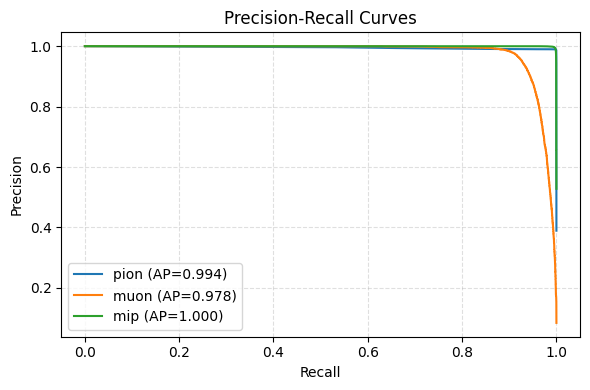

In [9]:
# 3. Precision-Recall Curves
print("3. Generating precision-recall curves...")
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_precision_recall.png",
    show=True,
)

### Probability Distributions

Show how well separated the probability distributions are for each class. These plots display the predicted probabilities (after softmax) for each hit type.

**How to interpret:**
- **Probability values**: After applying softmax, predictions are converted to probabilities (0-1).
- **Histogram shape**: 
  - Sharp peak near 1.0 for correct class = confident, accurate predictions
  - Broad distribution = uncertain predictions
  - Peak near 0.0 for incorrect classes = good discrimination

**What to look for:**
- Strong peaks at high probability for the correct class indicate confident, accurate predictions
- Low probabilities for incorrect classes show good discrimination



4. Generating probability distribution plots...


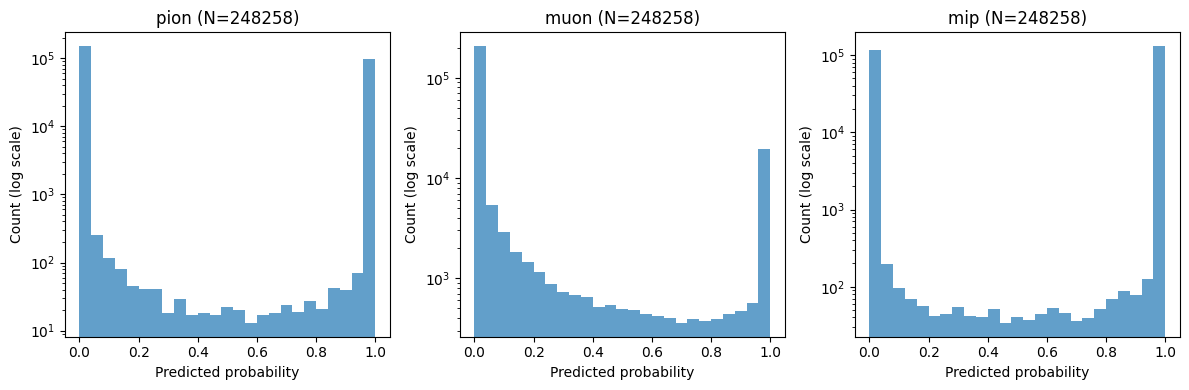

In [10]:
# 4. Probability Distributions
print("4. Generating probability distribution plots...")
plot_probability_distributions(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_probability_distributions.png",
    show=True,
)

### Confidence Analysis

Analyze the model's confidence in its predictions across different classes and prediction thresholds.

**How to interpret:**
- Shows how confident the model is in its predictions
- Helps identify where the model is uncertain
- Can reveal calibration issues

**What to look for:**
- High confidence for correct predictions indicates good calibration
- Low confidence for incorrect predictions shows the model knows when it's uncertain



5. Generating confidence analysis plots...


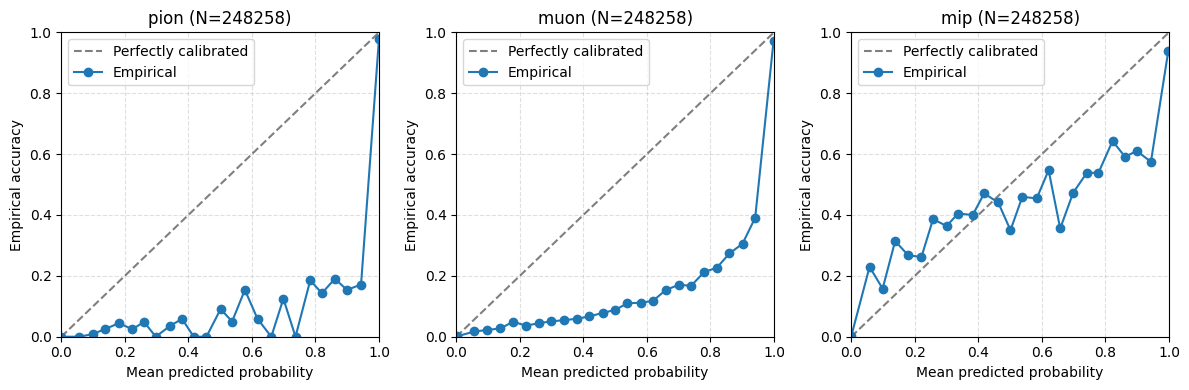

In [11]:
# 5. Confidence Analysis
print("5. Generating confidence analysis plots...")
plot_confidence_analysis(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_confidence_analysis.png",
    show=True,
)

# Optional embedding/input-space projections
embeddings = predictions.detach().cpu()
targets_for_emb = targets.detach().cpu()

plot_embedding_space(
    embeddings=embeddings,
    targets=targets_for_emb,
    class_names=class_names,
    method="pca",
    title="Prediction Space (PCA)",
    n_components=2,
    random_state=42,
    show=True,
    max_samples=8000,
    pre_pca_components=50,
    save_path=plots_dir / f"{plot_prefix}_prediction_space_pca.png",
    verbose=True,
)

loader = GroupSplitterGraphLoader(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    mode="train",
    batch_size=256,
    row_groups_per_chunk=4,
    num_workers=0,
)
input_feats = []
input_targets = []
for batch in loader.make_dataloader(shuffle_batches=False):
    x = batch.x.cpu()
    y = batch.y.cpu()
    b = batch.batch.cpu()
    num_graphs = int(batch.num_graphs)
    for gid in range(num_graphs):
        idx = torch.nonzero(b == gid, as_tuple=False).view(-1)
        if idx.numel() == 0:
            continue
        input_feats.append(x[idx].mean(dim=0).numpy())
        input_targets.append(y[idx].max(dim=0).values.numpy())
        if len(input_feats) >= 8000:
            break
    if len(input_feats) >= 8000:
        break

if len(input_feats) > 2:
    plot_embedding_space(
        embeddings=np.asarray(input_feats, dtype=np.float32),
        targets=np.asarray(input_targets, dtype=np.float32),
        class_names=class_names,
        method="pca",
        title="Input Feature Space (PCA)",
        n_components=2,
        random_state=42,
        show=True,
        max_samples=8000,
        pre_pca_components=4,
        save_path=plots_dir / f"{plot_prefix}_input_space_pca.png",
        verbose=True,
    )

print(f"Saved validation plots to: {plots_dir}")